In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [11]:
from src.sympy_utilities import *
from src.BinaryEncodings import *
from src.MatrixToPauliString import *
from src.qiskit_utilities import *

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import os
import json
import math

In [3]:
h_b_HO = 0.5*(p*p + m*m*q*q)
h_f_HO = -0.5*m#[bdag,b]

ham=Hamiltonian(h_b_HO,h_f_HO,{m:1, g:1}, 8, standard_encode)


In [4]:
hamOP = pauli_string_to_op(ham.pauliStrings)
nq=math.floor(math.log2(ham.hamMatrix.shape[0]))
if not math.log2(ham.hamMatrix.shape[0]).is_integer():
    nq+=1

In [5]:
estimator=Estimator()

In [7]:
if os.path.exists('Data/vqe_linear_real_amplitudes.json'):
    raFile=open('Data/vqe_linear_real_amplitudes.json')
    results=json.load(raFile)
else:
    results = {}    

vqeRuns=10

style = {'description_width': 'initial'}
layout = {'width':'600px'}

for entanglement in ['linear','reverse_linear','circular','sca']: #full and reverse linear are same, reverse has less gates
    if entanglement not in results:
        results[entanglement]={}

    for reps in [1,2,3,4]:
        ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=COBYLA(maxiter=5000*reps, tol=1e-4))
        
        values=[]
        iters=[]
        progress = IntProgress(min=0, max=vqeRuns, description="Running VQE with {} entanglement and {} reps".format(entanglement,reps), style=style, layout=layout)
        display(progress)

        for run in range(vqeRuns):
            result=vqe.compute_minimum_eigenvalue(hamOP)
            values.append(result.eigenvalue.real)
            iters.append(result.cost_function_evals)
            progress.value += 1
        
        if str(reps) in results[entanglement]:
            for value in values:
                results[entanglement][str(reps)]["eigenvalues"].append(value)
            for iter in iters:
                results[entanglement][str(reps)]["iters"].append(iter)

        else:
            results[entanglement][reps]={"eigenvalues": values, "iters": iters}
    
        with open('Data/vqe_linear_real_amplitudes.json','w') as file:
            json.dump(results, file)
        
        clear_output()

1.0 4.50262838125326e-09 188
2.0 1.389205284141326e-08 321
3.0 3.1372062836432235e-08 430
4.0 1.834992853222417e-07 1242
1.05 7.409597713170513e-09 171
2.05 1.3315088365217775e-08 239
3.05 8.59641867689831e-08 542
4.05 6.87931561715871e-08 793
1.1 3.9882773750221645e-09 206
2.1 6.556379994471229e-09 352
3.1 2.5901768840874695e-08 569
4.1 6.84005299067536e-08 619
1.15 9.421034952161733e-09 192
2.15 2.6348222492700302e-08 371
3.15 1.9669416206902213e-08 385
4.15 6.291676435399296e-08 950


Text(0.5, 1.0, 'RealAmplitudes')

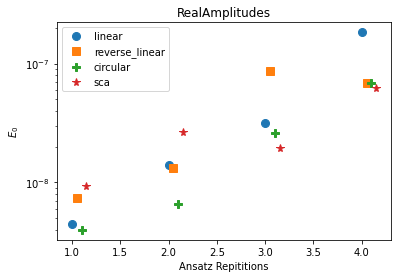

In [14]:
data={}
raFile=open('Data/vqe_linear_real_amplitudes.json')
#raFile=open('Data/vqe_linear_real_amplitudes_2kreps_1pm8.json')
data['RealAmplitudes']=json.load(raFile)
raFile.close()

amp='RealAmplitudes'
entanglements=data[amp].keys()

markersize=8
markers=['o','s','P','*']
colors=['tab:blue','tab:orange','tab:green','tab:red']

for i,entanglement in enumerate(entanglements):
    eMin = []
    iters = []
    reps=data[amp][entanglement].keys()

    for rep in reps:
        results=data[amp][entanglement][str(rep)]
        minIdx = np.argmin(np.array(results['eigenvalues']))
        eMin.append(results['eigenvalues'][minIdx])
        iters.append(results['iters'][minIdx])

    for rS, e, iter in zip(reps,eMin,iters):
        r=int(rS)
        print(r+0.05*i,e,iter)
        if iter==5000*r:
            plt.plot(r+0.05*i,e,marker=markers[i],markerfacecolor='none',markersize=markersize, color=colors[i])
        else:
            plt.plot(r+0.05*i,e,marker=markers[i],markersize=markersize, color=colors[i])

#    plt.scatter([int(r) for r in reps], eMin, marker=markers[i] ,label=entanglement)

plt.yscale('log')
plt.xlabel('Ansatz Repititions')
plt.ylabel(r'$E_0$')

lines = [mlines.Line2D([],[],color=colors[i], marker=markers[i], markersize=markersize, linestyle='None', label=ent) for i,ent in enumerate(entanglements)]

plt.legend(loc='upper left', handles=lines)
plt.title(amp)